# Investigating the Air Quality During the Thomas Fire

**Author:** Sujan Bhattarai  
**GitHub Repository:** [Investigating Air Quality - Thomas Fire](https://github.com/Sujan-Bhattarai12/task3-eds220)


## About

### Purpose
This repository serves as a comprehensive guide on archiving data from various sources for investigating the air quality index (AQI) during the Thomas fire in the Santa Barbara area. The data itself is not included in the GitHub repository but can be accessed via the links provided in the Data Citation section of the ReadMe file.

### Research Questions
1. **Impact of Thomas Fire on AQI in Santa Barbara:** Explore the effects of the Thomas fire on the Air Quality Index in the Santa Barbara area.
   
2. **False Color Imagery for Fire Detection:** Utilize false color imagery to accurately detect the location of the fire, employing invisible color bands.

3. **Time Series Analysis of AQI:** Investigate the time series of AQI values using a time-series moving average approach.

### Data Sources
- **False Color Raster Image:** Retrieved from the Microsoft Planetary Computer [catalog](https://planetarycomputer.microsoft.com/catalog).

- **California Shapefile:** Downloaded from the [California State GIS Data](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about).

- **Air Quality Data:**
  - [2017 Daily AQI Data](https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip)
  - [2018 Daily AQI Data](https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip)

### Note
The data is not stored within the repository but can be accessed through the provided links in the Data Citation section of the ReadMe file.

 

In [11]:
#load all required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd
from rasterio.features import rasterize

In [27]:
# load the netcdf data
data_path = os.path.join(os.getcwd(), "data/landsat8-2018-01-26-sb-simplified.nc")
landsat = rioxr.open_rasterio(data_path)
landsat

<xarray.Dataset>
Dimensions:      (y: 731, x: 870, band: 1)
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Data variables:
    red          (band, y, x) float64 ...
    green        (band, y, x) float64 ...
    blue         (band, y, x) float64 ...
    nir08        (band, y, x) float64 ...
    swir22       (band, y, x) float64 ...

In [13]:
# squeeze the band dimension, as it creates problem in plotting,
# also create dublicate, original unchanged might be required
landsat1 = landsat.squeeze(['band'])

In [30]:
# read the fire data available for california
fire = gpd.read_file("data/California_Fire_Perimeters_2017/California_Fire_Perimeters_2017.shp")
fire.describe()

,index,OBJECTID,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,SHAPE_Leng,SHAPE_Area
count,608.000000,608.000000,608.000000,608.000000,608.0,608.000000,608.000000,6.080000e+02
mean,20160.358553,41761.753289,8.077303,2.848684,1.0,2343.064262,13447.746625,1.537259e+07
std,261.936829,295.329361,5.225613,2.652306,0.0,14269.511290,44116.066523,8.983227e+07
min,19836.000000,41429.000000,1.000000,1.000000,1.0,0.001357,13.386707,-2.204240e+05
25%,19989.750000,41582.750000,2.000000,1.000000,1.0,9.405305,1193.667186,5.695604e+04
50%,20141.500000,41738.500000,9.000000,1.000000,1.0,28.121351,2425.248003,1.836226e+05
75%,20293.250000,41893.250000,14.000000,6.000000,1.0,143.994961,6012.417252,9.107243e+05
max,21906.000000,43892.000000,14.000000,8.000000,1.0,281790.875000,540531.887458,1.681106e+09


In [39]:
#select only thomas fire  
thomas_fire = fire[fire['FIRE_NAME'] == 'THOMAS'] 

#check if value is only Thomas 
for index, name in thomas_fire['FIRE_NAME'].iteritems():
    if name == 'THOMAS':
        print('All fires are named Thomas in this Data. "GOOD to GO"')

All fires are named Thomas in this Data. "GOOD to GO"


In [41]:
#change the crs to match with landsat                              
thomas_fire = thomas_fire.to_crs(landsat.rio.crs)

#validate if they are equal
thomas_fire.crs == landsat.rio.crs

True

In [45]:
#also save the false color image of the landsat, it will be required in plotting
false_color_data = landsat1[['swir22', 'nir08', 'red']].to_array()

#see the first few rows to observe if data is in correct format
false_color_data.head(3)

<xarray.DataArray (variable: 3, y: 3, x: 3)>
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 3.952e+06
  * x            (x) float64 1.213e+05 1.216e+05 1.218e+05
    band         int64 1
    spatial_ref  int64 0
  * variable     (variable) <U6 'swir22' 'nir08' 'red'

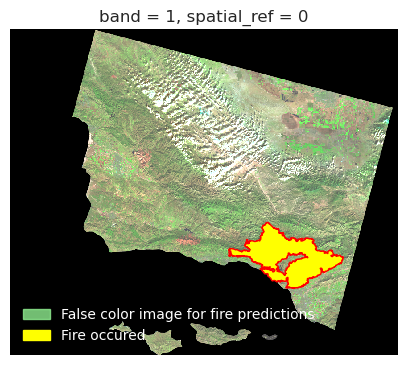

In [46]:
# Data is all set to plot
fig, ax = plt.subplots(figsize=(5, 5))

false_color_data.plot.imshow(ax=ax, cmap='inferno', robust = True)
ak_patch = mpatches.Patch(color='lightgreen', 
                          alpha = 0.8,
                          label='False color image for fire predictions')

thomas_fire.plot(ax=ax, edgecolor = 'red', color= 'yellow', alpha = 1)
kodiak_patch = mpatches.Patch(color='yellow', 
                              alpha = 1,
                              label='Fire occured')

ax.legend(handles = [ak_patch, kodiak_patch], 
          frameon=False, 
          loc='lower left',
          labelcolor = 'white' ) #create legend

ax.get_xaxis().set_visible(False) #remove xaxis label
ax.get_yaxis().set_visible(False) #remove yaxis label

The False color image clearly shows that AQI were changed during the Thomas fire.
Use the non-spatial ground data, avaialble for measuring station, and plot the time-series
air quality data.

In [18]:
##air quality index
##webscrape the two dataset based on the guidelines
aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip")
aqi_18 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip")

In [66]:
##concatnate the two datasets, this will be useful in plotting
aqi = pd.concat([aqi_17, aqi_18])

#check if both 2017 and 2018 data is present
print(f"{aqi['Date'].head(2)} \n {aqi['Date'].tail(2)}")

# re-assign the column names - .str.lower() makes them lower case
aqi.columns = aqi.columns.str.lower()

#  re-assign the column names again - .str.replace(' ','_') replaces the space for _
aqi.columns = aqi.columns.str.replace(' ','_')

0    2017-01-01
1    2017-01-04
Name: Date, dtype: object 
 327535    2018-12-30
327536    2018-12-31
Name: Date, dtype: object


In [67]:
##check the column names
aqi.columns

Index(['state_name', 'county_name', 'state_code', 'county_code', 'date', 'aqi',
       'category', 'defining_parameter', 'defining_site',
       'number_of_sites_reporting'],
      dtype='object')

In [18]:
# Select data from Santa Barbara county
aqi_sb = aqi[aqi['county_name'] == 'Santa Barbara']

# Remove specified columns
col_remove = ['state_name', 'county_name', 'state_code', 'county_code']
aqi_sb = aqi_sb.drop(columns=col_remove)

##date is in object format, and not in standard datetime python object
# Convert 'Date' column to datetime
aqi_sb['date'] = pd.to_datetime(aqi_sb['date'])  

# Set 'Date' as the index
aqi_sb.set_index('date', inplace=True)

In [68]:
#  DataFrame with the Date column as the index
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean()

## see the data distribution for average five day avearege data
aqi_sb.five_day_average.describe()

count    730.000000
mean      51.352009
std       18.659053
min       30.400000
25%       41.850000
50%       47.000000
75%       53.800000
max      199.200000
Name: five_day_average, dtype: float64

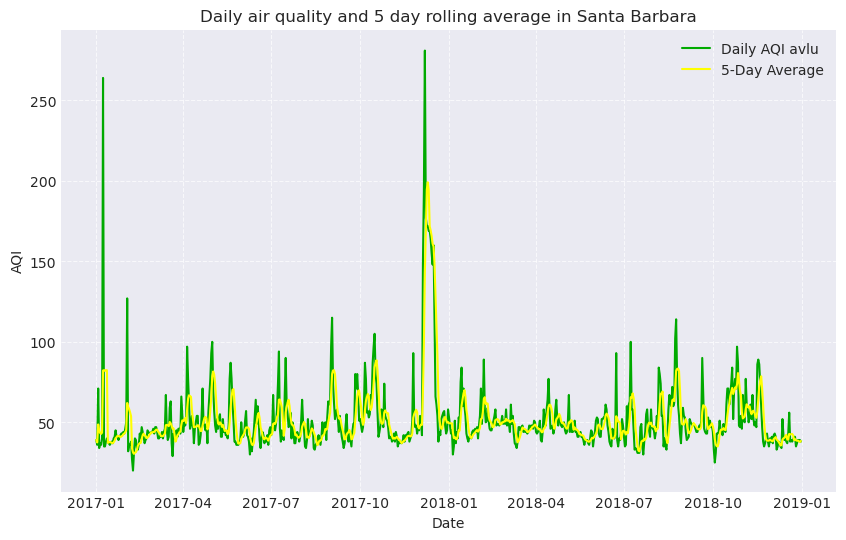

In [26]:
# Create a line plot using base matplotlib
plt.style.use('seaborn-darkgrid')

plt.figure(figsize=(10, 6))
plt.plot(aqi_sb.index, aqi_sb['aqi'], label='Daily AQI avlu', color='#00AA00')
plt.plot(aqi_sb.index, aqi_sb['five_day_average'], label='5-Day Average', color='#FFFF00')

# Set the title and labels
plt.title('Daily air quality and 5 day rolling average in Santa Barbara')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Customize x-axis date formatting 
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

plt.show()